In [565]:
# !pip install ipympl

In [566]:
import numpy as np
from google.colab import output
output.enable_custom_widget_manager()
%matplotlib widget

import matplotlib.pyplot as plt
from scipy.signal import welch
import matplotlib.patches as patches
from scipy.io import savemat

# Functions

In [567]:
def IQ_LUT(const):
    mapping_table_QAM16 = {
        (0,0,0,0) : -3-3j,
        (0,0,0,1) : -3-1j,
        (0,0,1,0) : -3+3j,
        (0,0,1,1) : -3+1j,
        (0,1,0,0) : -1-3j,
        (0,1,0,1) : -1-1j,
        (0,1,1,0) : -1+3j,
        (0,1,1,1) : -1+1j,
        (1,0,0,0) :  3-3j,
        (1,0,0,1) :  3-1j,
        (1,0,1,0) :  3+3j,
        (1,0,1,1) :  3+1j,
        (1,1,0,0) :  1-3j,
        (1,1,0,1) :  1-1j,
        (1,1,1,0) :  1+3j,
        (1,1,1,1) :  1+1j
    }
    demapping_table_QAM16 = {v : k for k, v in mapping_table_QAM16.items()}

    if const=='16QAM':
        mapping_table = mapping_table_QAM16
        demapping_table = demapping_table_QAM16

    return mapping_table, demapping_table

In [568]:
mapping_table, demapping_table = IQ_LUT('16QAM')

In [569]:
def SP(bits, rows, columns):
    # bits - signal to S/P
    # rows - num of subcarriers
    # columns - bits in IQ symbol

    return bits.reshape((rows, columns))

In [570]:
def Mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])

In [571]:
def OFDM_symbol(QAM_payload, K, N, Nfft):
    # QAM_payload - mapped data
    # Nfft - total amount of subcarriers
    # K - amount of data-subcarriers
    # N - total number of OFDM symbols transmitted

    symbols = np.zeros((Nfft,N), dtype=complex) # matrix [Nfft,N]
    data=QAM_payload.reshape((K,N))

    start = Nfft//2-K//2
    symbols[start:start+K,:] = data
    return symbols

In [572]:
def IDFT(OFDM_data,Nfft,N):
    OFDM_data2 = np.fft.ifftshift(OFDM_data,0)
    return np.fft.ifftn(OFDM_data2,[Nfft,N])

In [573]:
def power_set(signal, Sig_pow_dB):
    Sig_pow = 10**(Sig_pow_dB/10)
    power=np.mean(np.abs(signal)**2) # current mean power of the signal
    amp_factor = np.sqrt(Sig_pow/power)
    signal = amp_factor*signal
    return signal

In [574]:
def channel(signal,noise_dB):
    signal_power = np.mean(np.abs(signal)**2)
    sigma2=10**(noise_dB/10)
    SNRdB = 10*np.log10(signal_power/sigma2)
    print('SNR for given noise and signal power: %.4f Signal power in dB: %.4f' % (SNRdB, 10*np.log10(signal_power)))

    # Generate noise with given variance
    noise = np.sqrt(sigma2/2) * (np.random.randn(*signal.shape)+1j*np.random.randn(*signal.shape))
    noise_power = 10*np.log10(np.mean(np.abs(noise)**2))
    print('Noise power in dB: %.2f' % (noise_power))

    return noise, noise + signal

In [575]:
def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)

In [576]:
def Demapping(QAM):
    # array of possible constellation points
    constellation = np.array([x for x in demapping_table.keys()])

    # calculate distance of each RX point to each possible point
    dists = abs(QAM.reshape((-1,1)) - constellation.reshape((1,-1)))

    # for each element in QAM, choose the index in constellation
    # that belongs to the nearest constellation point
    const_index = dists.argmin(axis=1)

    # get back the real constellation point
    hardDecision = constellation[const_index]

    # transform the constellation point into the bit groups
    return np.vstack([demapping_table[C] for C in hardDecision]), hardDecision

In [577]:
def PS(bits):
    return bits.reshape((-1,))

# OFDM generator

## Parameters setting

In [578]:
Fc1 = 30e3 # in kHz n25 band carrier frequency
Fc2 = 30e3 # in kHz n66 band carrier frequency

K = 64 # number of used OFDM subcarriers
df = 2*10*1e3/K # scs in kHz, 2*Occupied_bandwidth[Mhz]*1e3/Subcarrier_num
Nfft = int(2048*2)

B = df*int(Nfft/2) #  bandwidth in Hz
print("Current Bandwidth: in kHz", B)
print("Current Occupied Bandwidth: in kHz", df*int(K/2))
Fs = B         # sampling frequency
N = 1000           # number of OFDM symbols transmitted

### Power
Sig_pow_dB = 90 # signal power in dB
noise_dB = 50  # noise power

### Carrier arrangement
# allCarriers = np.arange(Nfft)  # indices of all subcarriers ([0, 1, ... Nfft-1])
# dataCarriers = np.arange(K)    # indices of all data-subcarriers ([0, 1, ... K-1])
mu = 4 # bits per symbol (i.e. 16QAM)
payloadBits_per_OFDM = K*mu  # number of payload bits per OFDM symbol

Current Bandwidth: in kHz 640000.0
Current Occupied Bandwidth: in kHz 10000.0


In [579]:
##### Bits generation
np.random.seed(6)
bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM, N))
np.random.seed(65)
bits2 = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM, N))

##### S/P
bits_SP = SP(bits, N*K, mu)
bits_SP2 = SP(bits2, N*K, mu)

##### Mapping bits into constellation points
QAM = Mapping(bits_SP)
QAM2 = Mapping(bits_SP2)

##### OFDM-symbol creation
OFDM_data = OFDM_symbol(QAM, K,N, Nfft)
OFDM_data2 = OFDM_symbol(QAM2, K,N, Nfft)

##### IDFT operation (freq->time)
OFDM_time = IDFT(OFDM_data,Nfft,N)
OFDM_time2 = IDFT(OFDM_data2,Nfft,N)

t = np.arange(0, Nfft/Fs, 1/Fs)  # the time samples
f = np.arange(-Fs/2, Fs/2, Fs/Nfft)  # the corresponding frequency samples
s = OFDM_time
s_2 = OFDM_time2

##### Freqs shift in baseband
s1 = np.transpose(s)*np.exp(-1j*2*np.pi*Fc1*t)
s2 = np.transpose(s_2)*np.exp(1j*2*np.pi*Fc2*t)
s = np.transpose(s1+s2)

In [580]:
# Power setting
s_amp = power_set(s, Sig_pow_dB)

In [581]:
nperseg = 1024

s_amp=s_amp*np.sqrt(2*K/Nfft)  # normalization for FFT welch plot

noise, s_rx = channel(s_amp,noise_dB)

SNR for given noise and signal power: 24.9485 Signal power in dB: 74.9485
Noise power in dB: 50.00


In [582]:
s_noised=s_rx
s_noised.shape

(4096, 1000)

## Plot of the bandwith allocation

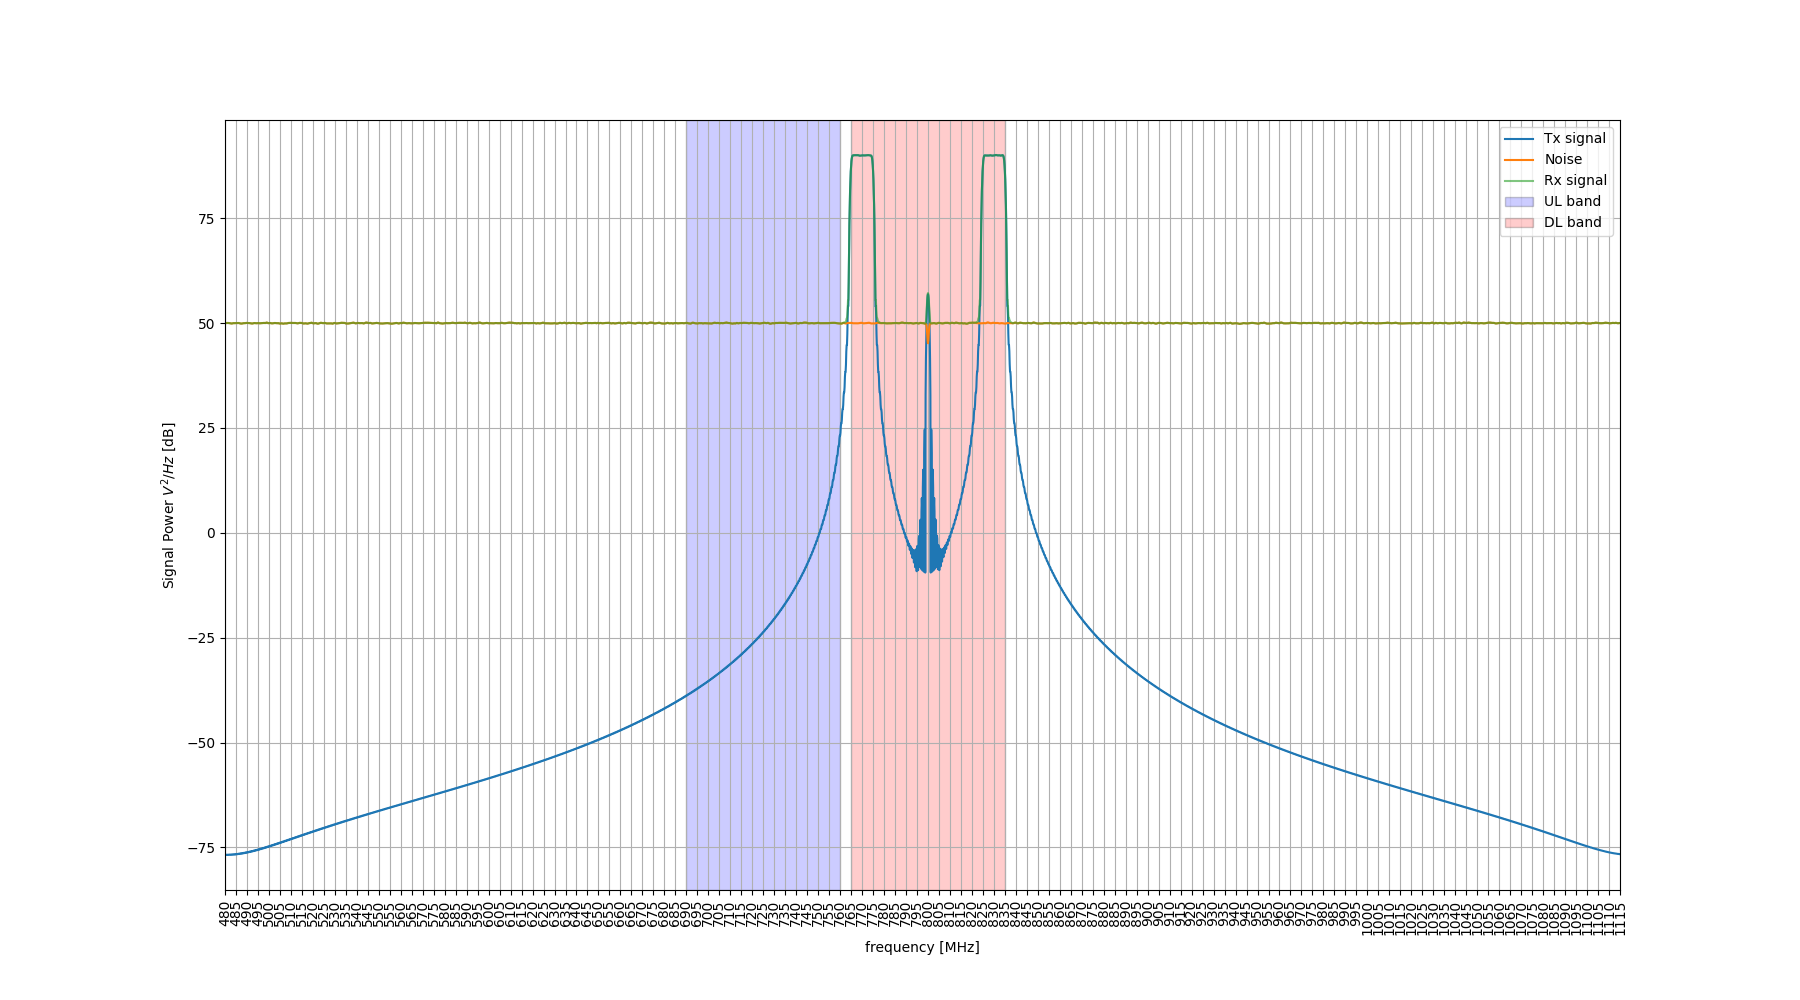

In [583]:
f, Pxx_spec = welch(np.transpose(s_amp), Fs, nperseg=nperseg, nfft=Nfft, return_onesided=False)
_, noise_spec = welch(np.transpose(noise), Fs, nperseg=nperseg, nfft=Nfft, return_onesided=False)
_, s_rx_spec = welch(np.transpose(s_rx), Fs, nperseg=nperseg, nfft=Nfft, return_onesided=False)

Pxx_spec = np.mean(Pxx_spec,0)
noise_spec = np.mean(noise_spec,0)
s_rx_spec = np.mean(s_rx_spec,0)

Pxx_dB=10*np.log10(np.abs(Pxx_spec)*Fs)
noise_spec_dB= 10*np.log10(np.abs(noise_spec)*Fs)
s_rx_spec_dB = 10*np.log10(np.abs(s_rx_spec)*Fs)

plt.figure(figsize=(18,10))
shift = 800e3 # in kHz
f_MHz = (f+shift) / 1e3

plt.plot(np.fft.fftshift(f_MHz), np.fft.fftshift(Pxx_dB), label='Tx signal')
plt.plot(np.fft.fftshift(f_MHz), np.fft.fftshift(noise_spec_dB), label='Noise')
plt.plot(np.fft.fftshift(f_MHz), np.fft.fftshift(s_rx_spec_dB), label='Rx signal', alpha=0.6)
plt.xlabel('frequency [MHz]')
plt.ylabel('Signal Power $V^2/Hz$ [dB]')
# plt.ylim(bottom=0)
plt.xlim(left=(-2*Fc1+shift)/1e3, right=(2*Fc2+shift)/1e3)

# Specify the UP-link bandwidth
bandwidth_up = 70 # in MHz
Fc_up = (Fc1+shift)/1e3-1.5*bandwidth_up # in MHz
up_band = patches.Rectangle((Fc_up - bandwidth_up / 2, plt.ylim()[0]),
                          bandwidth_up, plt.ylim()[1] - plt.ylim()[0],
                          linewidth=1, edgecolor='black', facecolor='blue',alpha = 0.2, label='UL band')
plt.gca().add_patch(up_band)

# Specify the DL-link bandwidth
bandwidth_dl = 70 # in MHz
Fc_dl = (shift)/1e3 # in MHz
dl_band = patches.Rectangle((Fc_dl - bandwidth_dl / 2, plt.ylim()[0]),
                          bandwidth_dl, plt.ylim()[1] - plt.ylim()[0],
                          linewidth=1, edgecolor='black', facecolor='red',alpha = 0.2, label='DL band')
plt.gca().add_patch(dl_band)

custom_bins = np.arange(np.min(f_MHz), np.max(f_MHz), 5)
plt.xticks(custom_bins, rotation='vertical')
plt.grid()
plt.legend()
plt.show()

# Tx antenna array

## Functions

In [584]:
def get_raw_pattern(angle_grid,type):
    """
    Initial patterns of the antenna elements
    """
    d2r = np.pi/180
    if type == "uniform":
        F = np.ones(len(angle_grid))
    elif type == "cos1":
        F = np.cos(0.5*angle_grid*d2r)**2
    elif type == "cos2":
        F = np.cos(angle_grid*d2r)**2
    elif type == "cos3":
        F = np.abs(np.cos(angle_grid*d2r))
    elif type == "cos4":
        F = np.cos(angle_grid*d2r)**32
    else:
        None

    # pattern normalization
    # F = F / np.sqrt(np.sum(np.abs(F)**2))
    return F

In [585]:
def plot_pattern_polar_lin(phi, r, title):
    plt.title(title)
    plt.polar(phi,r)

In [586]:
def plot_pattern_polar_dB(phi, r, title):
    plt.title(title)
    plt.polar(phi,10*np.log10(r))

## Tx antenna parameters

In [587]:
angles = np.arange(0,361,1)   # array of degrees
d2r=np.pi/180

AOD = 45                     # angle of departure in degrees - USER location
AOD_rad = AOD * d2r

Ntx = 4                       # number of Tx antenna elements
d = 0.5                       # half wavelength spacing

## Tx antenna response

In [588]:
F_tx = get_raw_pattern(angles,"cos3")
m_tx = F_tx[AOD]                    # element radiation pattern
M_tx=np.tile(m_tx,[Ntx,1])          # elements radiation pattern

A = np.exp(-2j * np.pi * d * np.arange(Ntx) * np.sin(AOD_rad))  # basic array response
A=A.reshape(-1,1)

AR = A * M_tx # array response = basic array response * element radiation pattern

<ipython-input-589-58ee5691698b>:1: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(projection = 'polar')


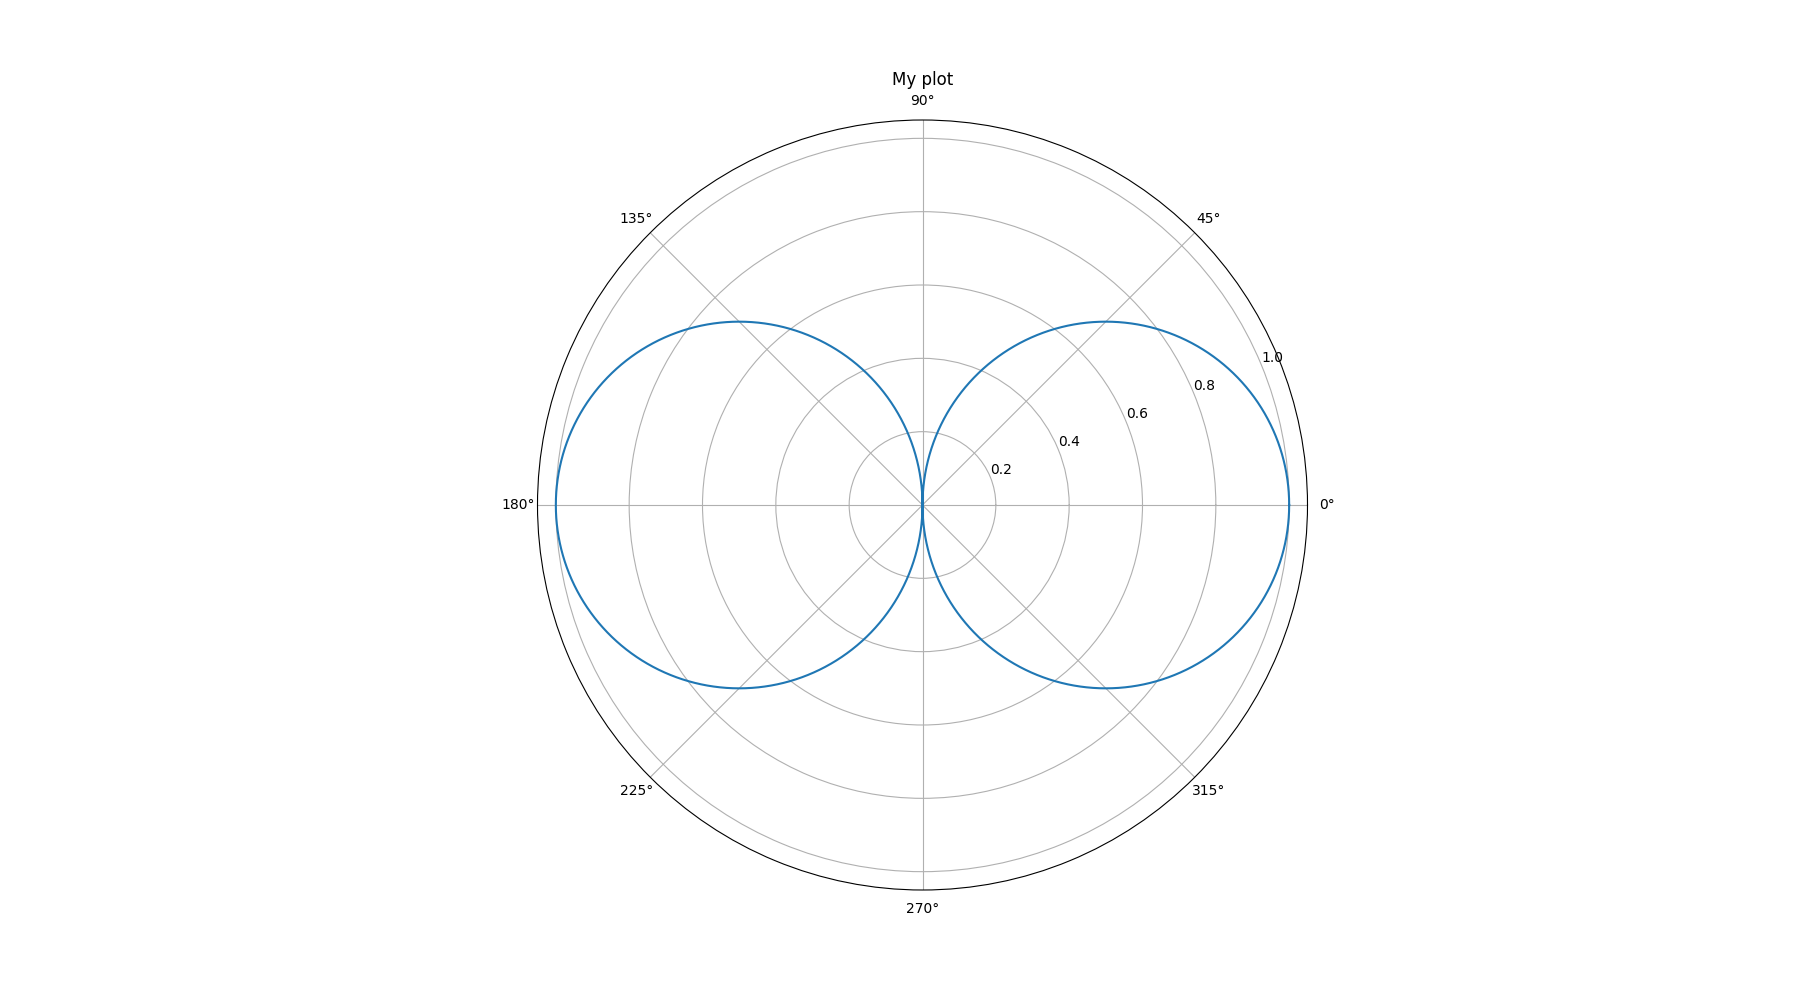

In [589]:
plt.subplot(projection = 'polar')
plot_pattern_polar_lin(angles*d2r,F_tx,"My plot")
plt.show()

## Tx Beamforming

In [590]:
s_noised.shape

(4096, 1000)

In [591]:
signal = s_noised
signal = signal.reshape(-1,1).T

# matrix multiply
tx_signal = np.kron(AR,signal) # tx_signal now is 2D array, 1D is time and 1D is the spatial dimension
# tx_signal = np.reshape(tx_signal,(Ntx,Nfft,N))

In [592]:
signal.shape, tx_signal.shape

((1, 4096000), (4, 4096000))

### Precode our signal in case of MISO

In [593]:
w = np.exp(-2j * np.pi * d * np.arange(Ntx) * np.sin(AOD_rad)) # Conventional, aka delay-and-sum, beamformer
w=w.reshape(-1,1)/np.linalg.norm(w) # reshape and norm our precoder
tx_precoded = w.conj().T @ tx_signal # apply our weights. remember r is 3x10000

### Plot radiation pattern of the precoded signal, spectrum of the precoded signal

In [594]:
# results = []
# for angle in angles:
#     w = np.exp(-2j * np.pi * d * np.arange(Ntx) * np.sin(angle*d2r)) # Conventional, aka delay-and-sum, beamformer
#     w=w.reshape(-1,1)/np.linalg.norm(w) # reshape and norm our precoder
#     r_weighted = w.conj().T @ tx_signal # apply our weights. remember r is 3x10000
#     results.append((np.mean(np.abs(r_weighted)**2))) # power in signal, in dB so its easier to see small and large lobes at the same time

In [595]:
# plt.subplot(projection = 'polar')
# plot_pattern_polar_dB(angles*d2r,np.array(results),"My plot")
# plt.show()

In [596]:
# f, Pxx_spec = welch(np.transpose(tx_precoded.T), Fs, nperseg=nperseg, nfft=Nfft, return_onesided=False)
# _, noise_spec = welch(np.transpose(noise), Fs, nperseg=nperseg, nfft=Nfft, return_onesided=False)
# _, s_rx_spec = welch(np.transpose(s_rx), Fs, nperseg=nperseg, nfft=Nfft, return_onesided=False)

# Pxx_spec = np.mean(Pxx_spec,0)
# noise_spec = np.mean(noise_spec,0)
# s_rx_spec = np.mean(s_rx_spec,0)

# Pxx_dB=10*np.log10(np.abs(Pxx_spec)*Fs)
# noise_spec_dB= 10*np.log10(np.abs(noise_spec)*Fs)
# s_rx_spec_dB = 10*np.log10(np.abs(s_rx_spec)*Fs)

# plt.figure(figsize=(18,10))
# shift = 800e3 # in kHz
# f_MHz = (f+shift) / 1e3

# plt.plot(np.fft.fftshift(f_MHz), np.fft.fftshift(Pxx_dB), label='Tx signal')
# plt.plot(np.fft.fftshift(f_MHz), np.fft.fftshift(noise_spec_dB), label='Noise')
# plt.plot(np.fft.fftshift(f_MHz), np.fft.fftshift(s_rx_spec_dB), label='Rx signal', alpha=0.6)
# plt.xlabel('frequency [MHz]')
# plt.ylabel('Signal Power $V^2/Hz$ [dB]')
# # plt.ylim(bottom=0)
# plt.xlim(left=(-2*Fc1+shift)/1e3, right=(2*Fc2+shift)/1e3)

# # Specify the UP-link bandwidth
# bandwidth_up = 70 # in MHz
# Fc_up = (Fc1+shift)/1e3-1.5*bandwidth_up # in MHz
# up_band = patches.Rectangle((Fc_up - bandwidth_up / 2, plt.ylim()[0]),
#                           bandwidth_up, plt.ylim()[1] - plt.ylim()[0],
#                           linewidth=1, edgecolor='black', facecolor='blue',alpha = 0.2, label='UL band')
# plt.gca().add_patch(up_band)

# # Specify the DL-link bandwidth
# bandwidth_dl = 70 # in MHz
# Fc_dl = (shift)/1e3 # in MHz
# dl_band = patches.Rectangle((Fc_dl - bandwidth_dl / 2, plt.ylim()[0]),
#                           bandwidth_dl, plt.ylim()[1] - plt.ylim()[0],
#                           linewidth=1, edgecolor='black', facecolor='red',alpha = 0.2, label='DL band')
# plt.gca().add_patch(dl_band)

# custom_bins = np.arange(np.min(f_MHz), np.max(f_MHz), 5)
# plt.xticks(custom_bins, rotation='vertical')
# plt.grid()
# plt.legend()
# plt.show()

# ePIM source configuration

## Input ePIM signal generation

In [597]:
AOD_PIM = 20                     # angle of departure in degrees - ePIM location
AOD_PIM_rad = AOD_PIM * d2r

In [598]:
F_tx = get_raw_pattern(angles,"cos3")
m_tx = F_tx[AOD_PIM]                    # element radiation pattern
M_tx=np.tile(m_tx,[Ntx,1])          # elements radiation pattern

A_PIM = np.exp(-2j * np.pi * d * np.arange(Ntx) * np.sin(AOD_PIM_rad))  # basic array response
A_PIM=A_PIM.reshape(-1,1)

AR_PIM = A_PIM * M_tx # array response = basic array response * element radiation pattern

In [599]:
signal_PIM = s_noised
signal_PIM = signal_PIM.reshape(-1,1).T

# matrix multiply
tx_signal_PIM = np.kron(AR_PIM,signal_PIM) # tx_signal now is 2D array, 1D is time and 1D is the spatial dimension
# tx_signal = np.reshape(tx_signal,(Ntx,Nfft,N))

In [600]:
w = np.exp(-2j * np.pi * d * np.arange(Ntx) * np.sin(AOD_rad)) # Apply same precoder as for USER
w=w.reshape(-1,1)/np.linalg.norm(w)
tx_precoded_PIM = w.conj().T @ tx_signal_PIM # apply our weights for signal towards ePIM

In [601]:
tx_precoded_PIM = np.reshape(np.squeeze(tx_precoded_PIM),(Nfft,N))

## Output ePIM signal generation

In [602]:
tx_PIM_out = tx_precoded_PIM*np.abs(tx_precoded_PIM)**2
#tx_PIM_out = s_amp*np.abs(s_amp)**2

In [603]:
alpha = np.sqrt(1)

In [604]:
Sig_pow=np.mean(np.abs(tx_precoded_PIM)**2) # current mean power of the Tx signal
power=np.mean(np.abs(tx_PIM_out)**2) # current mean power of the PIM
amp_factor = np.sqrt(Sig_pow/power)
tx_PIM_out = alpha*amp_factor*tx_PIM_out

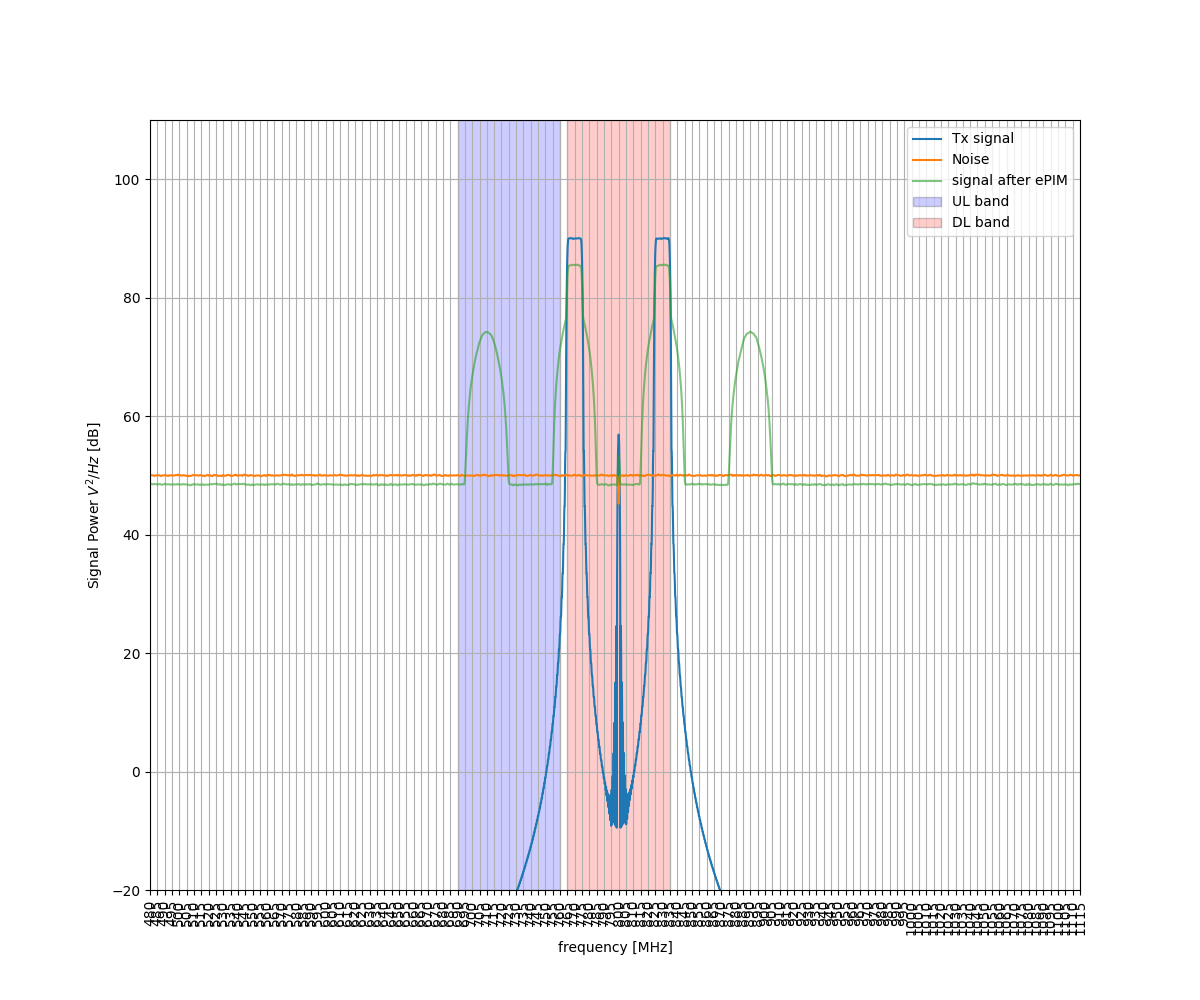

In [605]:
f, Pxx_spec = welch(np.transpose(s_amp), Fs, nperseg=nperseg, nfft=Nfft, return_onesided=False)
_, noise_spec = welch(np.transpose(noise), Fs, nperseg=nperseg, nfft=Nfft, return_onesided=False)
_, s_rx_spec = welch(np.transpose(s_rx), Fs, nperseg=nperseg, nfft=Nfft, return_onesided=False)
_, s_PIM = welch(np.transpose(tx_PIM_out), Fs, nperseg=nperseg, nfft=Nfft, return_onesided=False)

Pxx_spec = np.mean(Pxx_spec,0)
noise_spec = np.mean(noise_spec,0)
s_rx_spec = np.mean(s_rx_spec,0)
s_PIM_spec = np.mean(s_PIM,0)

Pxx_dB=10*np.log10(np.abs(Pxx_spec)*Fs)
noise_spec_dB= 10*np.log10(np.abs(noise_spec)*Fs)
s_rx_spec_dB = 10*np.log10(np.abs(s_rx_spec)*Fs)
s_PIM_dB = 10*np.log10(np.abs(s_PIM_spec)*Fs)

plt.figure(figsize=(12,10))
shift = 800e3 # in kHz
f_MHz = (f+shift) / 1e3

plt.plot(np.fft.fftshift(f_MHz), np.fft.fftshift(Pxx_dB), label='Tx signal')
plt.plot(np.fft.fftshift(f_MHz), np.fft.fftshift(noise_spec_dB), label='Noise')
#plt.plot(np.fft.fftshift(f_MHz), np.fft.fftshift(s_rx_spec_dB), label='Rx signal', alpha=0.6)
plt.plot(np.fft.fftshift(f_MHz), np.fft.fftshift(s_PIM_dB), label='signal after ePIM', alpha=0.6)
plt.xlabel('frequency [MHz]')
plt.ylabel('Signal Power $V^2/Hz$ [dB]')
plt.ylim(bottom=-20, top=110)
plt.xlim(left=(-5*Fc1+shift)/1e3, right=(5*Fc2+shift)/1e3)

# Specify the UP-link bandwidth
bandwidth_up = 70 # in MHz
Fc_up = (Fc1+shift)/1e3-1.5*bandwidth_up # in MHz
up_band = patches.Rectangle((Fc_up - bandwidth_up / 2, plt.ylim()[0]),
                          bandwidth_up, plt.ylim()[1] - plt.ylim()[0],
                          linewidth=1, edgecolor='black', facecolor='blue',alpha = 0.2, label='UL band')
plt.gca().add_patch(up_band)

# Specify the DL-link bandwidth
bandwidth_dl = 70 # in MHz
Fc_dl = (shift)/1e3 # in MHz
dl_band = patches.Rectangle((Fc_dl - bandwidth_dl / 2, plt.ylim()[0]),
                          bandwidth_dl, plt.ylim()[1] - plt.ylim()[0],
                          linewidth=1, edgecolor='black', facecolor='red',alpha = 0.2, label='DL band')
plt.gca().add_patch(dl_band)

custom_bins = np.arange(np.min(f_MHz), np.max(f_MHz), 5)
plt.xticks(custom_bins, rotation='vertical')
plt.grid()
plt.legend()
plt.show()

## ePIM signal back propagation

In [606]:
F_tx = get_raw_pattern(angles,"cos3")
m_tx = F_tx[AOD_PIM]                    # element radiation pattern
M_tx=np.tile(m_tx,[Ntx,1])          # elements radiation pattern

A_PIM_bp = np.exp(-2j * np.pi * d * np.arange(Ntx) * np.sin(AOD_PIM_rad))  # basic array response
A_PIM_bp=A_PIM_bp.reshape(-1,1)

A_PIM_bp = A_PIM_bp * M_tx # array response = basic array response * element radiation pattern

In [607]:
signal_PIM_bp = tx_PIM_out
signal_PIM_bp = signal_PIM_bp.reshape(-1,1).T

# matrix multiply
sig_PIM = np.kron(A_PIM_bp,signal_PIM_bp) # tx_signal now is 2D array, 1D is time and 1D is the spatial dimension

In [608]:
RX_sig_PIM = np.reshape(np.squeeze(sig_PIM),(Ntx,Nfft,N))

In [609]:
RX_sig_PIM_mean = np.squeeze(np.mean(RX_sig_PIM,2))
RX_sig_PIM_mean.shape

print(int(np.mean(np.abs(RX_sig_PIM_mean)**2)))

11650


45 - 14 \\
20 - 121 \\
19 - 120 \\
80 - 6 \\

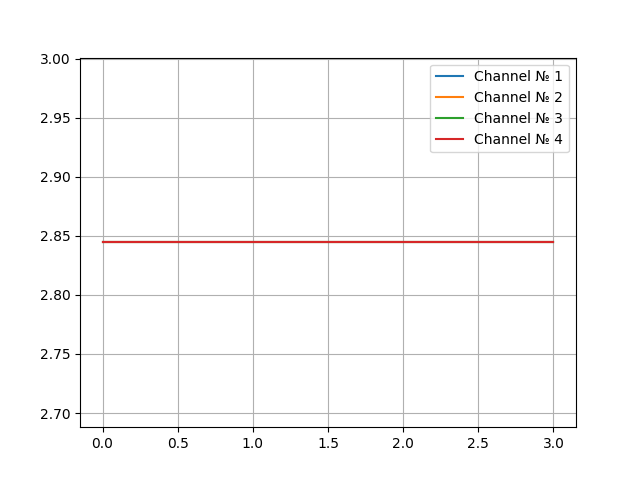

In [610]:
plt.figure()
for i in range(Ntx):
  namelabel = "Channel № " + str(i+1)
  plt.plot(np.squeeze((np.mean(np.abs(RX_sig_PIM_mean)**2,1)/Nfft)), label=namelabel)
plt.legend()
plt.grid()
plt.show()

## Plot received ePIM signal

In [611]:
# results = []
# for angle in angles:
#     w = np.exp(-2j * np.pi * d * np.arange(Ntx) * np.sin(angle*d2r)) # Conventional, aka delay-and-sum, beamformer
#     w=w.reshape(-1,1)/np.linalg.norm(w) # reshape and norm our precoder
#     r_weighted = w.conj().T @ sig_PIM # apply our weights. remember r is 3x10000
#     r_weighted = np.reshape(r_weighted,(N,Nfft))
#     r_weighted = np.mean(r_weighted,0)
#     results.append((np.mean(np.abs(r_weighted)**2))) # power in signal, in dB so its easier to see small and large lobes at the same time

In [612]:
# plt.figure()
# plt.subplot(projection = 'polar')
# plot_pattern_polar_dB(angles*d2r,np.array(results),"My plot")
# plt.show()

In [613]:
# results = []
# for angle in angles:
#     w = np.exp(-2j * np.pi * d * np.arange(Ntx) * np.sin(angle*d2r)) # Conventional, aka delay-and-sum, beamformer
#     w=w.reshape(-1,1)/np.linalg.norm(w) # reshape and norm our precoder
#     r_weighted = w.conj().T @ tx_signal # apply our weights. remember r is 3x10000
#     results.append((np.mean(np.abs(r_weighted)**2))) # power in signal, in dB so its easier to see small and large lobes at the same time

In [614]:
# plt.subplot(projection = 'polar')
# plot_pattern_polar_dB(angles*d2r,np.array(results),"My plot")
# plt.show()